### CS4622 Mini Kaggle Competition - Multiclass Image Classification - Shallow Network - Hyperparameter Tuning
#### Author: Sabine Hollatz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# %tensorflow_version 2.x
import tensorflow as tf

import seaborn as sns

In [2]:
X_train = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/X_train.npy')
y_train = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/y_train.npy')
X_test = np.load('../../data_comp4/cuboulder-image-labelling/train_and_test/X_test.npy')
print("Number of samples: {}, number of classes: {}".format(y_train.shape[0], y_train.shape[1]))
print("image size: {}x{}x{}".format(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

Number of samples: 39209, number of classes: 43
image size: 32x32x3


In [3]:
num_imgs = X_train.shape[0]
print(num_imgs)
X_train_flattened = np.array([X_train[i].flatten() for i in range(0, num_imgs)])

X_train_flattened.shape

39209


(39209, 3072)

In [4]:
# hyperparameter tuning
def build_model(num_hidden=1, num_neurons=30, learning_rate=3e-3, input_shape=[3072]):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(num_hidden):
    model.add(tf.keras.layers.Dense(num_neurons, activation="relu"))
  model.add(tf.keras.layers.Dense(43, activation="softmax"))
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
  return model

In [5]:
keras_cls = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [6]:
param_distribs = {
    'num_hidden': [0,1,2,3,4,5],
    'num_neurons': [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'learning_rate': [5e-5, 1e-5, 5e-4, 1e-4, 9e-3, 7e-3, 5e-3, 3e-3, 1e-3, 9e-2, 5e-2]
}

rnd_search_cv = RandomizedSearchCV(keras_cls, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_flattened, y_train, epochs=40, verbose=0)

13069/13069 [==============================] - 1s 91us/sample - loss: 22.1625 - accuracy: 0.0000e+00


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcdedac1890>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [5e-05, 1e-05, 0.0005,
                                                          0.0001, 0.009, 0.007,
                                                          0.005, 0.003, 0.001,
                                                          0.09, 0.05],
                                        'num_hidden': [0, 1, 2, 3, 4, 5],
                                        'num_neurons': [1, 50, 100, 150, 200,
                                                        250, 300, 350, 400, 450,
                                                        500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [7]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
model = rnd_search_cv.best_estimator_.model

{'num_neurons': 200, 'num_hidden': 0, 'learning_rate': 0.005}
0.04736157451882925


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format = "channels_last")

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    data_format = "channels_last")

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(32,32,3)))
model.add(tf.keras.layers.Dense(43, activation='softmax'))
    
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

In [11]:
epochs = 100
batchsize = 128
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=batchsize), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batchsize),
                    steps_per_epoch=len(X_train) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245.0546875 steps, validate for 62 steps
Epoch 1/100
246/245 [==============================] - 1s 5ms/step - loss: 2.1584 - categorical_accuracy: 0.5471 - val_loss: 1.3392 - val_categorical_accuracy: 0.7135
Epoch 2/100
246/245 [==============================] - 1s 5ms/step - loss: 1.0441 - categorical_accuracy: 0.7669 - val_loss: 0.8632 - val_categorical_accuracy: 0.8097
Epoch 3/100
246/245 [==============================] - 2s 6ms/step - loss: 0.7848 - categorical_accuracy: 0.8249 - val_loss: 0.8251 - val_categorical_accuracy: 0.7933
Epoch 4/100
246/245 [==============================] - 1s 4ms/step - loss: 0.6455 - categorical_accuracy: 0.8545 - val_loss: 0.7343 - val_categorical_accuracy: 0.8531
Epoch 5/100
246/245 [==============================] - 1s 4ms/step - loss: 0.5623 - categorical_accuracy: 0.8736 - val_loss: 0.5062 - val_categorical_accuracy: 0.8973
Epoch 6/100
246/245 [==============================] - 1s 4ms/st

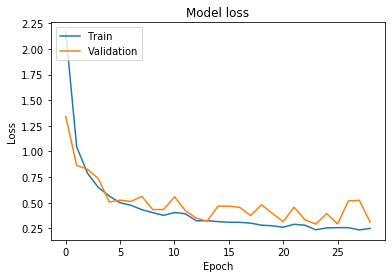

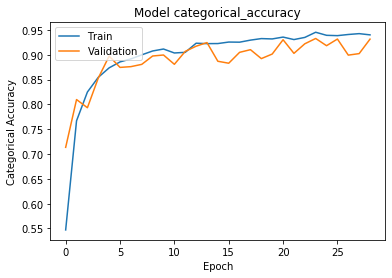

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model categorical_accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
predictions = model.predict(X_test)

In [14]:
preds_to_submit = pd.DataFrame(predictions.astype('int'))

In [15]:
preds_to_submit.to_csv("./shallow_network_predictions_hyperparameter_tuning.csv")

In [16]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=(32,32,3)))
model2.add(tf.keras.layers.Dense(43, activation='softmax'))
    
callback = tf.keras.callbacks.EarlyStopping(monitor='categorical_accuracy', patience=5)

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

In [17]:
epochs = 100
batchsize = 128
history = model2.fit(train_datagen.flow(X_train, y_train, batch_size=batchsize), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batchsize),
                    steps_per_epoch=len(X_train) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245.0546875 steps, validate for 62 steps
Epoch 1/100
246/245 [==============================] - 1s 5ms/step - loss: 3.2091 - categorical_accuracy: 0.2186 - val_loss: 2.8951 - val_categorical_accuracy: 0.3352
Epoch 2/100
246/245 [==============================] - 1s 4ms/step - loss: 2.6860 - categorical_accuracy: 0.4189 - val_loss: 2.5085 - val_categorical_accuracy: 0.4705
Epoch 3/100
246/245 [==============================] - 2s 6ms/step - loss: 2.3710 - categorical_accuracy: 0.5095 - val_loss: 2.2526 - val_categorical_accuracy: 0.5325
Epoch 4/100
246/245 [==============================] - 1s 4ms/step - loss: 2.1506 - categorical_accuracy: 0.5702 - val_loss: 2.0605 - val_categorical_accuracy: 0.5997
Epoch 5/100
246/245 [==============================] - 1s 4ms/step - loss: 1.9822 - categorical_accuracy: 0.6193 - val_loss: 1.9185 - val_categorical_accuracy: 0.6350
Epoch 6/100
246/245 [==============================] - 1s 4ms/st

246/245 [==============================] - 1s 4ms/step - loss: 0.6194 - categorical_accuracy: 0.9066 - val_loss: 0.6563 - val_categorical_accuracy: 0.8931
Epoch 49/100
246/245 [==============================] - 1s 5ms/step - loss: 0.6117 - categorical_accuracy: 0.9067 - val_loss: 0.6459 - val_categorical_accuracy: 0.8928
Epoch 50/100
246/245 [==============================] - 1s 5ms/step - loss: 0.6030 - categorical_accuracy: 0.9093 - val_loss: 0.6423 - val_categorical_accuracy: 0.8944
Epoch 51/100
246/245 [==============================] - 1s 5ms/step - loss: 0.5955 - categorical_accuracy: 0.9109 - val_loss: 0.6342 - val_categorical_accuracy: 0.8961
Epoch 52/100
246/245 [==============================] - 1s 5ms/step - loss: 0.5880 - categorical_accuracy: 0.9114 - val_loss: 0.6271 - val_categorical_accuracy: 0.8965
Epoch 53/100
246/245 [==============================] - 1s 6ms/step - loss: 0.5813 - categorical_accuracy: 0.9126 - val_loss: 0.6198 - val_categorical_accuracy: 0.8968
Epoch

Epoch 97/100
246/245 [==============================] - 1s 5ms/step - loss: 0.3878 - categorical_accuracy: 0.9402 - val_loss: 0.4363 - val_categorical_accuracy: 0.9241
Epoch 98/100
246/245 [==============================] - 1s 6ms/step - loss: 0.3857 - categorical_accuracy: 0.9398 - val_loss: 0.4351 - val_categorical_accuracy: 0.9241
Epoch 99/100
246/245 [==============================] - 2s 6ms/step - loss: 0.3828 - categorical_accuracy: 0.9402 - val_loss: 0.4340 - val_categorical_accuracy: 0.9217
Epoch 100/100
246/245 [==============================] - 1s 5ms/step - loss: 0.3804 - categorical_accuracy: 0.9414 - val_loss: 0.4293 - val_categorical_accuracy: 0.9236


In [18]:
epochs = 100
batchsize = 128
history2 = model2.fit(train_datagen.flow(X_train, y_train, batch_size=batchsize), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batchsize),
                    steps_per_epoch=len(X_train) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245.0546875 steps, validate for 62 steps
Epoch 1/100
246/245 [==============================] - 1s 4ms/step - loss: 0.3773 - categorical_accuracy: 0.9416 - val_loss: 0.4274 - val_categorical_accuracy: 0.9240
Epoch 2/100
246/245 [==============================] - 1s 5ms/step - loss: 0.3744 - categorical_accuracy: 0.9416 - val_loss: 0.4248 - val_categorical_accuracy: 0.9253
Epoch 3/100
246/245 [==============================] - 1s 6ms/step - loss: 0.3718 - categorical_accuracy: 0.9421 - val_loss: 0.4229 - val_categorical_accuracy: 0.9253
Epoch 4/100
246/245 [==============================] - 1s 5ms/step - loss: 0.3696 - categorical_accuracy: 0.9429 - val_loss: 0.4196 - val_categorical_accuracy: 0.9250
Epoch 5/100
246/245 [==============================] - 1s 4ms/step - loss: 0.3670 - categorical_accuracy: 0.9433 - val_loss: 0.4201 - val_categorical_accuracy: 0.9235
Epoch 6/100
246/245 [==============================] - 1s 5ms/st

246/245 [==============================] - 1s 5ms/step - loss: 0.2889 - categorical_accuracy: 0.9551 - val_loss: 0.3496 - val_categorical_accuracy: 0.9339
Epoch 49/100
246/245 [==============================] - 1s 5ms/step - loss: 0.2871 - categorical_accuracy: 0.9556 - val_loss: 0.3466 - val_categorical_accuracy: 0.9333
Epoch 50/100
246/245 [==============================] - 1s 6ms/step - loss: 0.2862 - categorical_accuracy: 0.9542 - val_loss: 0.3447 - val_categorical_accuracy: 0.9359
Epoch 51/100
246/245 [==============================] - 1s 6ms/step - loss: 0.2847 - categorical_accuracy: 0.9554 - val_loss: 0.3452 - val_categorical_accuracy: 0.9327
Epoch 52/100
246/245 [==============================] - 1s 5ms/step - loss: 0.2834 - categorical_accuracy: 0.9546 - val_loss: 0.3432 - val_categorical_accuracy: 0.9342
Epoch 53/100
246/245 [==============================] - 1s 5ms/step - loss: 0.2819 - categorical_accuracy: 0.9548 - val_loss: 0.3414 - val_categorical_accuracy: 0.9361
Epoch

Epoch 97/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2350 - categorical_accuracy: 0.9636 - val_loss: 0.3030 - val_categorical_accuracy: 0.9393
Epoch 98/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2343 - categorical_accuracy: 0.9634 - val_loss: 0.3004 - val_categorical_accuracy: 0.9403
Epoch 99/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2334 - categorical_accuracy: 0.9635 - val_loss: 0.3001 - val_categorical_accuracy: 0.9406
Epoch 100/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2327 - categorical_accuracy: 0.9632 - val_loss: 0.2988 - val_categorical_accuracy: 0.9420


In [19]:
epochs = 100
batchsize = 128
history3 = model2.fit(train_datagen.flow(X_train, y_train, batch_size=batchsize), 
                    validation_data=val_datagen.flow(X_val, y_val, batch_size=batchsize),
                    steps_per_epoch=len(X_train) / batchsize,
                    shuffle=True,
                    callbacks=[callback],
                    epochs=epochs)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 245.0546875 steps, validate for 62 steps
Epoch 1/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2322 - categorical_accuracy: 0.9635 - val_loss: 0.2982 - val_categorical_accuracy: 0.9420
Epoch 2/100
246/245 [==============================] - 1s 5ms/step - loss: 0.2315 - categorical_accuracy: 0.9636 - val_loss: 0.2990 - val_categorical_accuracy: 0.9397
Epoch 3/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2304 - categorical_accuracy: 0.9643 - val_loss: 0.2971 - val_categorical_accuracy: 0.9397
Epoch 4/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2294 - categorical_accuracy: 0.9639 - val_loss: 0.2964 - val_categorical_accuracy: 0.9415
Epoch 5/100
246/245 [==============================] - 1s 4ms/step - loss: 0.2285 - categorical_accuracy: 0.9644 - val_loss: 0.2979 - val_categorical_accuracy: 0.9410
Epoch 6/100
246/245 [==============================] - 1s 5ms/st

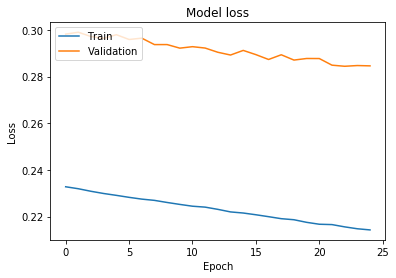

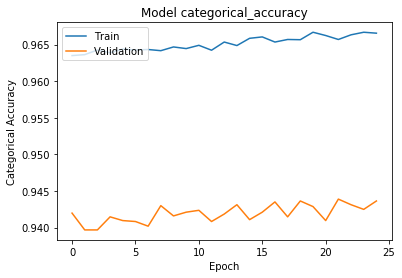

In [21]:
# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('Model categorical_accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
predictions2 = model2.predict(X_test)

In [23]:
preds_to_submit2 = pd.DataFrame(predictions2.astype('int'))

In [24]:
preds_to_submit.to_csv("./shallow_network_predictions_hypterparameter_tuning2.csv")